In [88]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error

In [134]:
def get_signal_generator(batch_size, n_points, mean_distance, std_distance, 
                         mean_width, std_width):
    def generate_one():
        first = np.random.uniform(0, n_points /4)
        second = first + np.random.normal(mean_distance * n_points, std_distance * n_points)
        if second > n_points * 0.95:
            second = n_points * 0.95
        distance = second - first
        first_width = max(np.random.normal(mean_width * n_points, std_width * n_points), n_points * std_width)
        second_width = max(np.random.normal(mean_width * n_points, std_width * n_points), n_points * std_width)
        data_range = np.arange(n_points)
        signal = norm.pdf(data_range, first, first_width) + \
            norm.pdf(data_range, second, second_width)
        return signal, distance
        
    def generate():
        sanity=100000
        for _ in range(sanity):
            all_data = [generate_one() for _ in range(batch_size)]
            yield np.vstack([element[0] for element in all_data]), np.vstack([element[1] for element in all_data])
        
    return generate()

In [135]:
data_generator = get_signal_generator(2, 1000, 0.3, 0.1, 0.03, 0.01)
batch = next(data_generator)

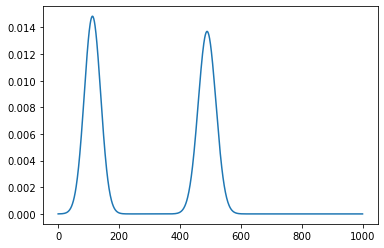

In [136]:
plt.plot(batch[0][0,:]);

## Finding peaks

Now that we have the generator functtion we can  use the standard signal processing library to find the distance between peaks

In [137]:
def predict_distance(batch):
    def compute_distance(row):
        peaks = find_peaks(row)[0]
        if len(peaks) < 2:
            return 0
        return abs(peaks[1] - peaks[0])
                   
    return np.vstack([compute_distance(batch[i,:]) for i in range(batch.shape[0])])
    

Now we evaluate our base model

In [138]:
np.random.seed(2128506)
data_generator = get_signal_generator(500, 1000, 0.7, 0.1, 0.03, 0.01)
batch_x, batch_y = next(data_generator)

In [139]:
predictions = predict_distance(batch_x)
print('Baseline performance: ', r2_score(batch_y, predictions))

Baseline performance:  0.9999812121197582


## Fitting a deep learning model

In [140]:
from tensorflow.keras.layers import Conv1D, Dense, Input
from tensorflow.keras import Sequential

In [141]:
model = Sequential([
    Dense(100,input_shape=(1000,), activation='relu'),
    Dense(1)
])

In [149]:
model.compile(optimizer='sgd', loss='mse')

In [150]:
np.random.seed(2128506)
data_generator = get_signal_generator(500, 1000, 0.7, 0.1, 0.03, 0.01)
model.fit(data_generator, epochs=50, steps_per_epoch=100)

Epoch 1/50
100/100 [==============================] - 46s 455ms/step - loss: 4656988.5000
Epoch 2/50
100/100 [==============================] - 47s 473ms/step - loss: 13425.7549
Epoch 3/50
100/100 [==============================] - 48s 479ms/step - loss: 7920.5815
Epoch 4/50
100/100 [==============================] - 47s 472ms/step - loss: 7722.8882
Epoch 5/50
100/100 [==============================] - 48s 480ms/step - loss: 7771.6514
Epoch 6/50
100/100 [==============================] - 48s 479ms/step - loss: 7815.7598
Epoch 7/50
100/100 [==============================] - 46s 464ms/step - loss: 7789.9072
Epoch 8/50
100/100 [==============================] - 47s 467ms/step - loss: 7783.6143
Epoch 9/50
100/100 [==============================] - 47s 467ms/step - loss: 7733.8374
Epoch 10/50
100/100 [==============================] - 14s 136ms/step - loss: 7820.0225
Epoch 11/50
100/100 [==============================] - 18s 177ms/step - loss: 7830.9746
Epoch 12/50
100/100 [================

In [151]:
batch_x, batch_y = next(data_generator)
predictions = model.predict(batch_x)
print('R^2 score: ', r2_score(batch_y, predictions))

R^2 score:  -0.00011996042538386931
